# Polymers Around Nano Particles

This tutorial demonstrates how to simulate polymers around **impenetrable particles** using a masking approach. The propagator is set to zero inside the particle region, modeling exclusion effects.

**What you'll learn:**
- Using masks to define impenetrable regions
- Simulating polymers grafted near particles
- Computing propagators that respect spatial constraints
- Visualizing polymer depletion zones around particles

**Prerequisites:** Complete `00_QuickStart.ipynb`, `Diblock.ipynb`, and `GraftingPoints.ipynb` first.

**References:**
- [(2021) How a Polymer Brush Interacts with Inclusions and Alters Their Interaction](https://doi.org/10.1021/acs.macromol.0c02179)
- [(2025) Variations of the Depletion Zones around Inclusions Explain the Complexity of Brush-Induced Depletion Interactions](https://doi.org/10.1021/acs.jctc.5c00334)

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"      # Single-threaded OpenMP
os.environ["OMP_NUM_THREADS"] = "1"      # Single-threaded FFTW

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from polymerfts import PropagatorSolver

## 2. Simulation Parameters

| Parameter | Value | Description |
|-----------|-------|-------------|
| $N$ | 100 | Reference chain length |
| $\Delta s$ | 0.01 | Contour step size (= $1/N$) |
| $L_x, L_y$ | $6.0 R_0$ | Box dimensions |
| $m_x, m_y$ | 128 | Grid points per dimension |
| $b_A/b$ | 1.0 | Statistical segment length |
| $R_{\text{particle}}$ | $1.0 R_0$ | Nano particle radius |

In [2]:
# Simulation parameters
nx = [128,128]                 # grid number
lx = [6.0,6.0]                 # box size
ds = 0.01                      # contour step interval
stat_seg_lengths = {"A":1.0}   # statistical segment lengths

## 3. Define the Particle Mask

The mask defines accessible and impenetrable regions:

$$\text{mask}(\mathbf{r}) = \begin{cases} 1 & \text{accessible region} \\ 0 & \text{impenetrable region (inside particle)} \end{cases}$$

After each propagation step, the propagator is multiplied by the mask, enforcing $q(\mathbf{r}, s) = 0$ inside the particle.

Particle volume fraction: 0.0875
Expected (pi*R^2/V): 0.0873


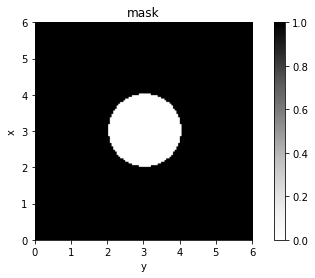

In [3]:
# Create the mask for the nano particle
x = np.linspace(-lx[0]/2, lx[0]/2, num=nx[0], endpoint=False)
y = np.linspace(-lx[1]/2, lx[1]/2, num=nx[1], endpoint=False)

xv, yv = np.meshgrid(x, y, indexing='ij')
nano_particle_radius = 1.0
mask = np.ones(nx)
mask[np.sqrt(xv**2 + yv**2) < nano_particle_radius] = 0.0

# Check 1/V int dr (1-mask(r))
print(f"Particle volume fraction: {1.0-np.mean(mask):.4f}")
print(f"Expected (pi*R^2/V): {(np.pi*nano_particle_radius**2)/np.prod(lx):.4f}")

# Visualize the mask
fig, axes = plt.subplots(figsize=(8, 4))
im = axes.imshow(mask, extent=(0, lx[1], 0, lx[0]), origin="lower", cmap=cm.Greys)
axes.set(title='mask', xlabel='y', ylabel='x')
fig.colorbar(im)
plt.show()

## 4. Create PropagatorSolver with Mask

We create a `PropagatorSolver` with the mask parameter to define the impenetrable particle region.

In [4]:
# Create PropagatorSolver with mask
solver = PropagatorSolver(
    nx=nx, lx=lx,
    ds=ds,
    bond_lengths=stat_seg_lengths,
    bc=["periodic"]*4,
    chain_model="continuous",
    method="pseudospectral",
    platform="cpu-fftw",
    reduce_memory=False,
    mask=mask
)

# Add homopolymer with grafting point at node 0
solver.add_polymer(
    volume_fraction=1.0,
    blocks=[["A", 1.0, 0, 1]],
    grafting_points={0: "G"}
)

## 5. Set Initial Conditions and Potential Fields

The initial condition $q_{\text{init}}(\mathbf{r}; G)$ is set to a delta function along a line at $x = 1.5 R_0$, representing chains grafted at a fixed distance from the box center.

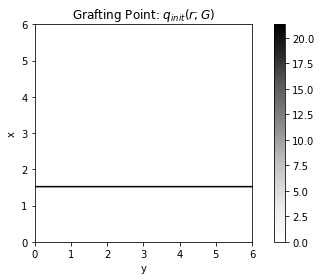

In [5]:
# Set initial conditions for the propagator
dv = solver.get_dv()
q_init = {"G": np.zeros(nx)}
q_init["G"][32, :] = 1.0 / (lx[0]/nx[0])  # Delta function along a line

plt.figure(figsize=(8, 4))
plt.title('Grafting Point: $q_{init}(r; G)$')
plt.xlabel('y')
plt.ylabel('x')
plt.imshow(q_init["G"][:, :], extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.Greys)
plt.colorbar()
plt.show()

# Zero potential field (free chain)
w_A = np.zeros(nx)

## 6. Compute Partition Function and Concentrations

The partition function $Q$ measures the total statistical weight of all chain conformations that avoid the particle.

In [6]:
# Compute propagators with custom initial condition
solver.compute_propagators({"A": w_A}, q_init=q_init)

# Get single chain partition function
Q = solver.get_partition_function(polymer=0)
print(f"Q = {Q:.6f}")

# Compute ensemble average concentration
solver.compute_concentrations()

Q = 0.152222


## 7. Visualize Propagator Evolution

The animations show how the propagator evolves along the chain contour while avoiding the particle region. The forward propagator $q^{0 \rightarrow 1}_0(\mathbf{r}, s)$ starts from the grafting line, and the backward propagator $q^{1 \rightarrow 0}_0(\mathbf{r}, s)$ starts from the chain end.

In [7]:
import matplotlib.animation as animation
from IPython.display import HTML

# Create an animation of the chain propagator (0 → 1)
p, v, u = 0, 0, 1
fig, ax = plt.subplots(figsize=(8, 4))
fig.suptitle('Chain Propagator $q^{0 \\rightarrow 1}_0$')
im = ax.imshow(np.reshape(solver.get_propagator(polymer=p, v=v, u=u, step=0), nx)[:, :],
               extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.Greys)
fig.colorbar(im, ax=ax)

def update(frame):
    data = np.reshape(solver.get_propagator(polymer=p, v=v, u=u, step=frame), nx)[:, :]
    im.set_array(data)
    im.set_clim(vmin=np.min(data), vmax=np.max(data))
    return [im]

anim = animation.FuncAnimation(fig, update, frames=100, interval=1, repeat=False)
plt.close(fig)

HTML(anim.to_jshtml())

In [8]:
# Create an animation of the chain propagator (1 → 0)
p, v, u = 0, 1, 0
fig, ax = plt.subplots(figsize=(8, 4))
fig.suptitle('Chain Propagator $q^{1 \\rightarrow 0}_0$')
im = ax.imshow(np.reshape(solver.get_propagator(polymer=p, v=v, u=u, step=0), nx)[:, :],
               extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.Greys)
fig.colorbar(im, ax=ax)

def update(frame):
    data = np.reshape(solver.get_propagator(polymer=p, v=v, u=u, step=frame), nx)[:, :]
    im.set_array(data)
    im.set_clim(vmin=0.0, vmax=1.0)
    return [im]

anim = animation.FuncAnimation(fig, update, frames=100, interval=1, repeat=False)
plt.close(fig)

HTML(anim.to_jshtml())

## 8. Summary

In this tutorial, we learned:

1. **Masks for impenetrable regions**: Setting propagator to zero inside particles using the `mask` parameter
2. **PropagatorSolver with mask**: Pass `mask` to define particle exclusion zones
3. **Grafted polymers near particles**: Combining custom initial conditions with masks
4. **Depletion zones**: Polymers are excluded from regions near the particle surface

### Physical Insights

- The propagator "wraps around" the particle, showing depletion zones
- This approach is useful for studying polymer-nanoparticle composites, brush-particle interactions, and depletion forces

### Next Steps

- **Non-periodic boundaries**: See `NonPeriodicBC.ipynb`
- **Self-consistent field theory**: See `../SelfConsistentFieldTheory/`
- **Production simulations**: See `examples/scft/` for full SCFT with particles